In [1]:
import torch
import numpy as np
from hmc_u1 import HMC_U1
from hmc_u1_ft import HMC_U1_FT
from cnn_model import FieldTransformation
from utils import hmc_summary


In [2]:
# Parameters
lattice_size = 32
volume = lattice_size ** 2
beta = 8
n_thermalization_steps = 200
n_steps = 50
step_size = 0.1
n_iterations = 2048

# Initialize device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'

# Set default type
torch.set_default_dtype(torch.float32)

### No Field Transformation

>>> No Field Transformation HMC Simulation: 


Thermalizing:   0%|          | 0/200 [00:00<?, ?it/s]

Running HMC: 100%|██████████| 2048/2048 [00:24<00:00, 83.48it/s]


>>> Simulation completed


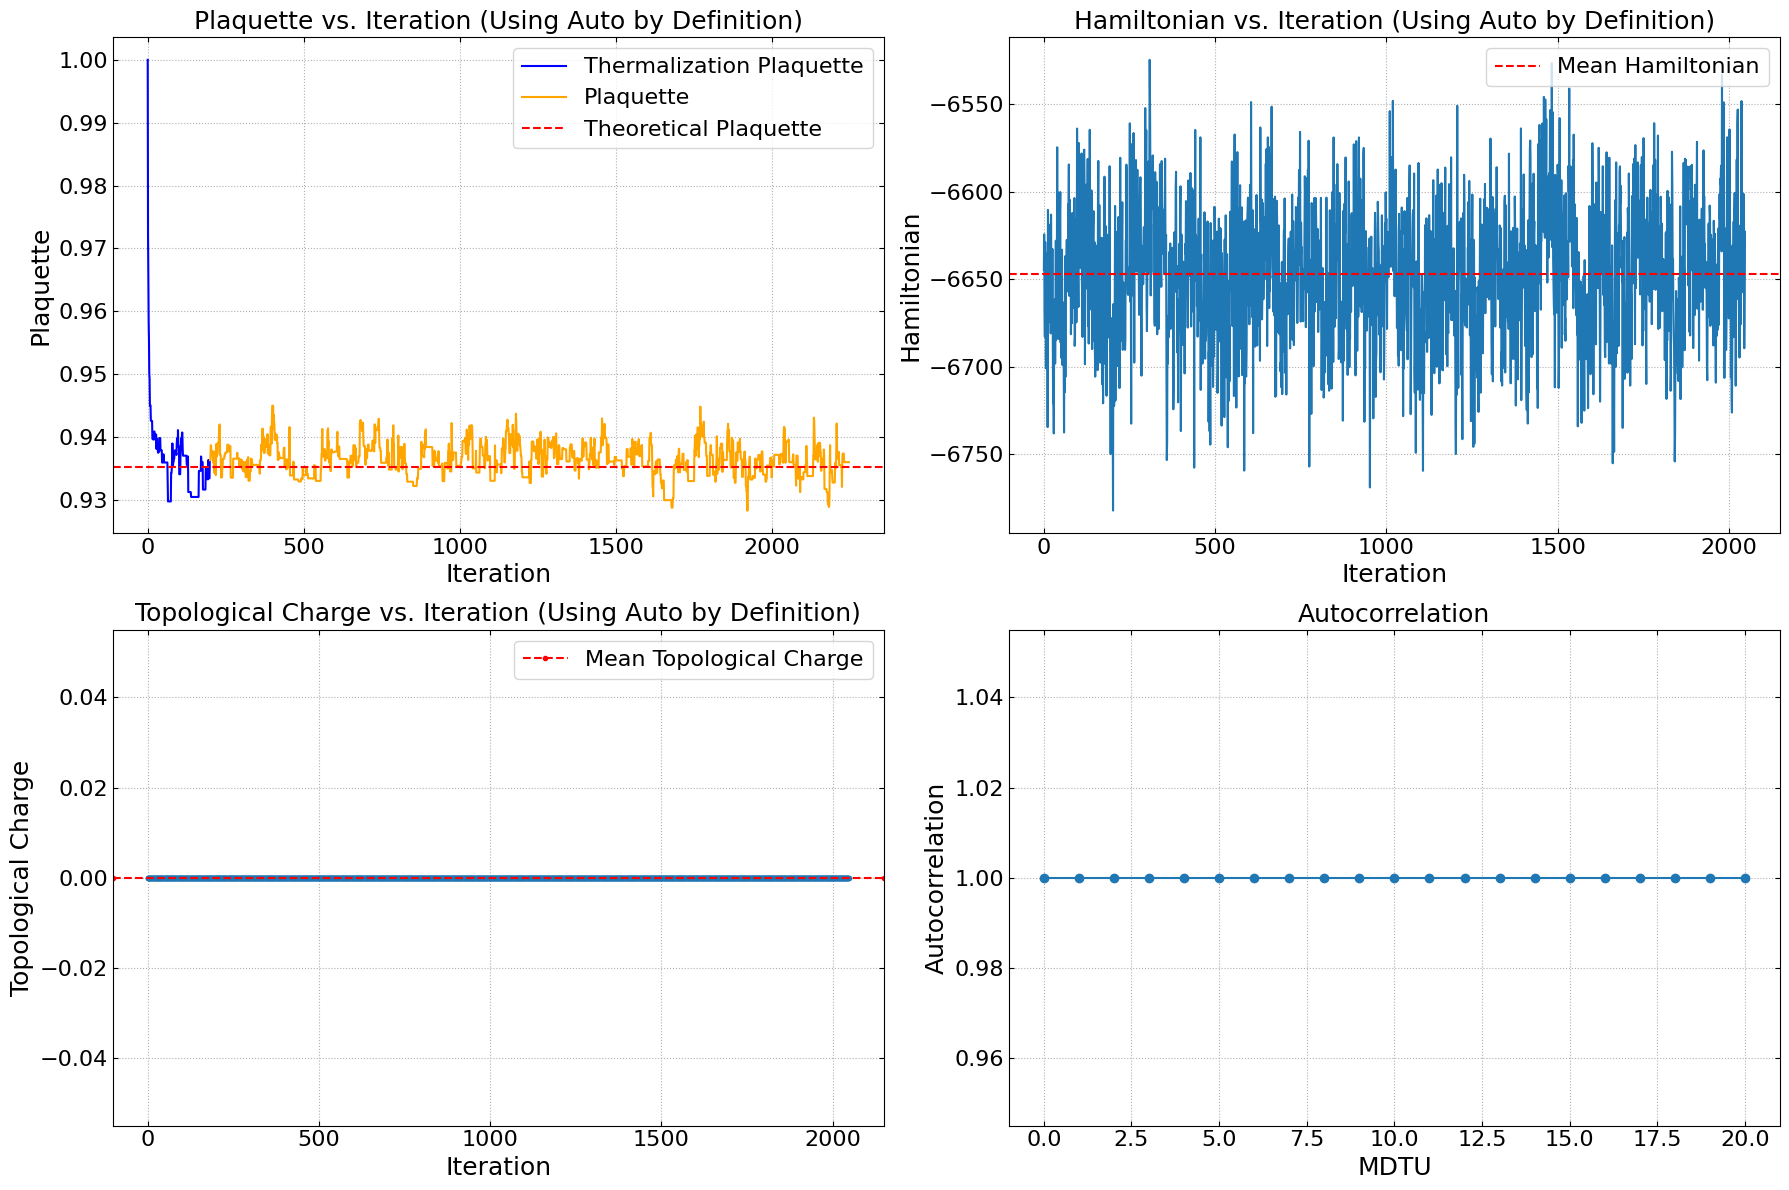

>>> Theoretical plaquette:  0.9352354935294382
>>> Mean plaq:  0.9363336876849644
>>> Std of mean plaq:  5.5403347867888234e-05
Thermalization acceptance rate: 0.3650
Acceptance rate: 0.3584


In [3]:
print(">>> No Field Transformation HMC Simulation: ")

# Initialize HMC
hmc = HMC_U1(lattice_size, beta, n_thermalization_steps, n_steps, step_size, device=device)

# Thermalize the system
theta_thermalized, therm_plaq_ls, therm_acceptance_rate = hmc.thermalize()

# Run HMC without field transformation
config_ls, plaq_ls, acceptance_rate, topological_charges, hamiltonians = hmc.run(n_iterations, theta_thermalized)

print(">>> Simulation completed")


# Compute autocorrelation of topological charges
max_lag = 20
hmc_fig = hmc_summary(beta, max_lag, volume, therm_plaq_ls, plaq_ls, topological_charges, hamiltonians, therm_acceptance_rate, acceptance_rate)
hmc_fig.savefig(f'plots/hmc_L{lattice_size}_beta{beta}.pdf', transparent=True)

# Save configurations for training
np.save(f'dump/theta_ori_L{lattice_size}_beta{beta}.npy', torch.stack(config_ls).detach().cpu().numpy())


### Neural Network Field Transformation

>>> Neural Network Field Transformation HMC Simulation: 


/home/jinchen/miniconda3/envs/lat/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Loaded data shape: torch.Size([2048, 2, 32, 32])
Training data shape: torch.Size([1638, 2, 32, 32])
Testing data shape: torch.Size([410, 2, 32, 32])
>>> Training the model


Training epochs:   6%|▋         | 1/16 [01:29<22:19, 89.27s/it]

Epoch 1/16 - Train Loss: 10.461004 - Test Loss: 6.840153


Training epochs:  12%|█▎        | 2/16 [03:00<21:02, 90.19s/it]

Epoch 2/16 - Train Loss: 6.343134 - Test Loss: 6.110389


Training epochs:  19%|█▉        | 3/16 [04:31<19:38, 90.62s/it]

Epoch 3/16 - Train Loss: 6.037951 - Test Loss: 6.005741


Training epochs:  25%|██▌       | 4/16 [06:02<18:09, 90.82s/it]

Epoch 4/16 - Train Loss: 5.963563 - Test Loss: 5.949651


Training epochs:  31%|███▏      | 5/16 [07:33<16:39, 90.90s/it]

Epoch 5/16 - Train Loss: 5.913847 - Test Loss: 5.904659


Training epochs:  38%|███▊      | 6/16 [09:02<15:02, 90.26s/it]

Epoch 6/16 - Train Loss: 5.871378 - Test Loss: 5.866951


Training epochs:  44%|████▍     | 7/16 [10:32<13:30, 90.07s/it]

Epoch 7/16 - Train Loss: 5.835420 - Test Loss: 5.833422


Training epochs:  50%|█████     | 8/16 [12:01<11:59, 89.97s/it]

Epoch 8/16 - Train Loss: 5.803323 - Test Loss: 5.804819


Training epochs:  56%|█████▋    | 9/16 [13:31<10:29, 89.89s/it]

Epoch 9/16 - Train Loss: 5.775936 - Test Loss: 5.779529


Training epochs:  62%|██████▎   | 10/16 [15:01<08:59, 89.91s/it]

Epoch 10/16 - Train Loss: 5.751372 - Test Loss: 5.757667


Training epochs:  69%|██████▉   | 11/16 [16:30<07:28, 89.71s/it]

Epoch 11/16 - Train Loss: 5.731015 - Test Loss: 5.738960


Training epochs:  75%|███████▌  | 12/16 [18:15<06:17, 94.29s/it]

Epoch 12/16 - Train Loss: 5.712442 - Test Loss: 5.722896


Training epochs:  81%|████████▏ | 13/16 [19:47<04:40, 93.66s/it]

Epoch 13/16 - Train Loss: 5.696472 - Test Loss: 5.708186


Training epochs:  88%|████████▊ | 14/16 [21:18<03:05, 92.86s/it]

Epoch 14/16 - Train Loss: 5.683306 - Test Loss: 5.695187


Training epochs:  94%|█████████▍| 15/16 [22:48<01:31, 91.86s/it]

Epoch 15/16 - Train Loss: 5.670142 - Test Loss: 5.684292


Training epochs: 100%|██████████| 16/16 [24:23<00:00, 91.44s/it]

Epoch 16/16 - Train Loss: 5.659269 - Test Loss: 5.673609


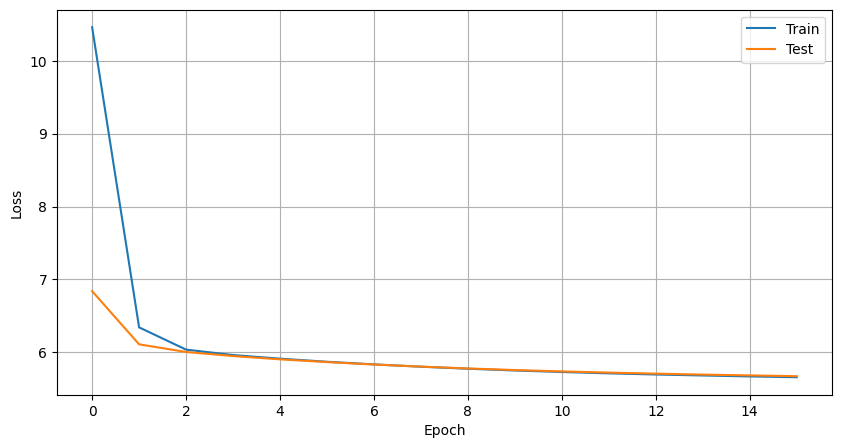

/home/jinchen/git/anl/hmc_ft/2d_u1_rep/cnn_model.py:352: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('models/best_model.pt')
/tmp/ipykernel_1187535

Loaded best models from epoch 15 with loss 5.673609
>>> Saving the trained models
>>> Models saved successfully
>>> Loading the trained models
>>> Models loaded successfully


Running HMC: 100%|██████████| 2048/2048 [52:29<00:00,  1.54s/it] 


>>> Simulation completed


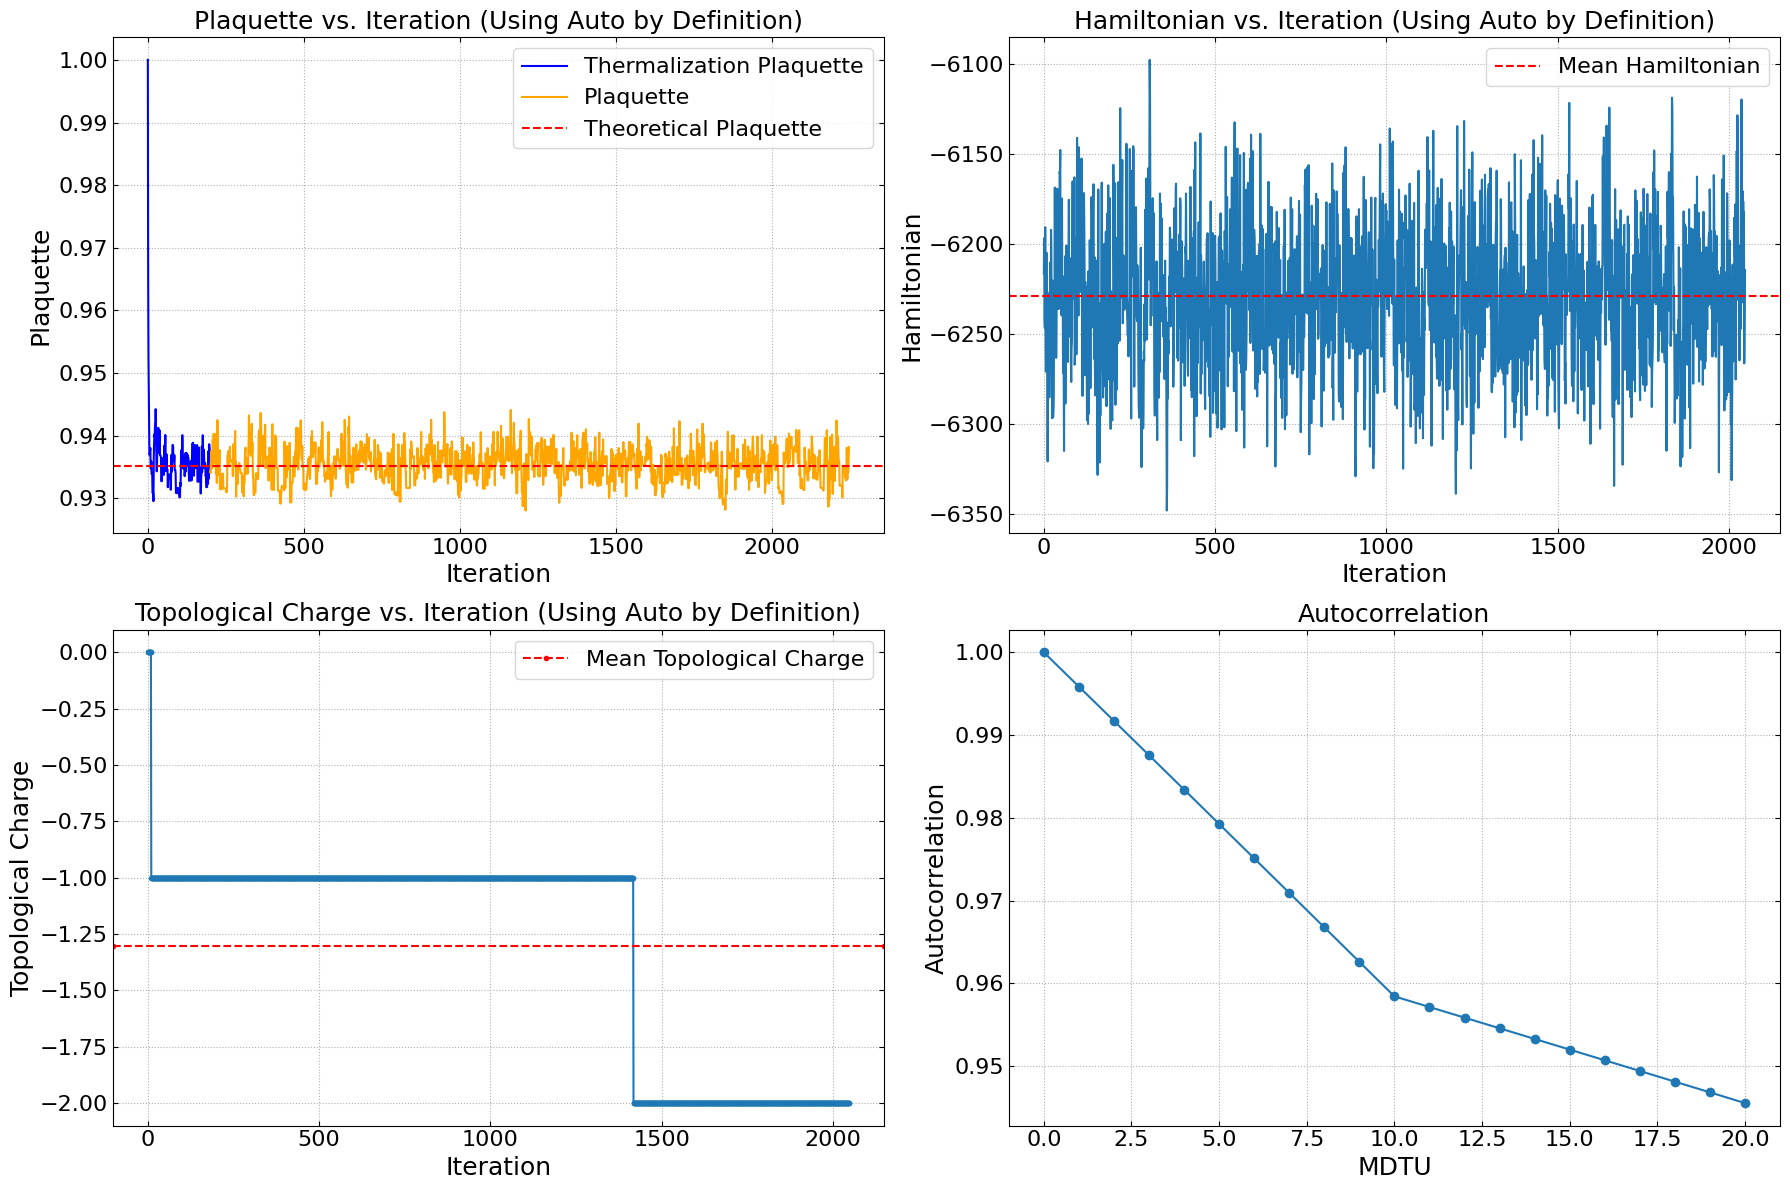

>>> Theoretical plaquette:  0.9352354935294382
>>> Mean plaq:  0.9353491613583174
>>> Std of mean plaq:  5.885598682925546e-05
Thermalization acceptance rate: 0.6800
Acceptance rate: 0.6562


In [4]:
print(">>> Neural Network Field Transformation HMC Simulation: ")

# initialize the field transformation
nn_ft = FieldTransformation(lattice_size, device=device, n_subsets=8)
# nn_ft.model.load_state_dict(torch.load('models/cnn_save.pt'), weights_only=False)

# load the data
data = np.load(f'dump/theta_ori_L{lattice_size}_beta{beta}.npy')
tensor_data = torch.from_numpy(data).float().to(device)
print(f"Loaded data shape: {tensor_data.shape}")

# split the data into training and testing
train_size = int(0.8 * len(tensor_data))
train_data = tensor_data[:train_size]
test_data = tensor_data[train_size:]
print(f"Training data shape: {train_data.shape}")
print(f"Testing data shape: {test_data.shape}")

# train the model
print(">>> Training the model")
nn_ft.train(train_data, test_data, beta, n_epochs=16, batch_size=16)

# Save the trained models
print(">>> Saving the trained models")
save_dict = {}
for i, model in enumerate(nn_ft.models):
    save_dict[f'model_{i}'] = model.state_dict()
torch.save(save_dict, 'models/cnn_trained.pt')
print(">>> Models saved successfully")

# Load the trained models
print(">>> Loading the trained models")
saved_models = torch.load('models/cnn_trained.pt')
for i, model in enumerate(nn_ft.models):
    model.load_state_dict(saved_models[f'model_{i}'])
    model.eval()
print(">>> Models loaded successfully")


field_transformation = nn_ft.field_transformation
compute_jac_logdet = nn_ft.compute_jac_logdet

# Initialize HMC with field transformation
hmc = HMC_U1_FT(lattice_size, beta, n_thermalization_steps, n_steps, step_size, field_transformation=field_transformation, compute_jac_logdet=compute_jac_logdet, device=device)

# Thermalize the system
theta_thermalized, therm_plaq_ls, therm_acceptance_rate = hmc.thermalize()

# Run HMC without field transformation
final_config, plaq_ls, acceptance_rate, topological_charges, hamiltonians = hmc.run(n_iterations, theta_thermalized)

print(">>> Simulation completed")


# Compute autocorrelation of topological charges
max_lag = 20
hmc_fig = hmc_summary(beta, max_lag, volume, therm_plaq_ls, plaq_ls, topological_charges, hamiltonians, therm_acceptance_rate, acceptance_rate)
hmc_fig.savefig(f'plots/hmc_ft_L{lattice_size}_beta{beta}.pdf', transparent=True)
